# Solving steady-state flow with a graph-based DFN structure

### Problem statement
We propose a method to quickly estimate flow in a DFN and to avoid the computational burden associated with DFN meshing and flow solving. The method consists in solving steady-state flow on a graph-based structure equivalent to the DFN. Two structures are possible: a graph of fractures and a graph of intersections. Both are presented in this tutorial.

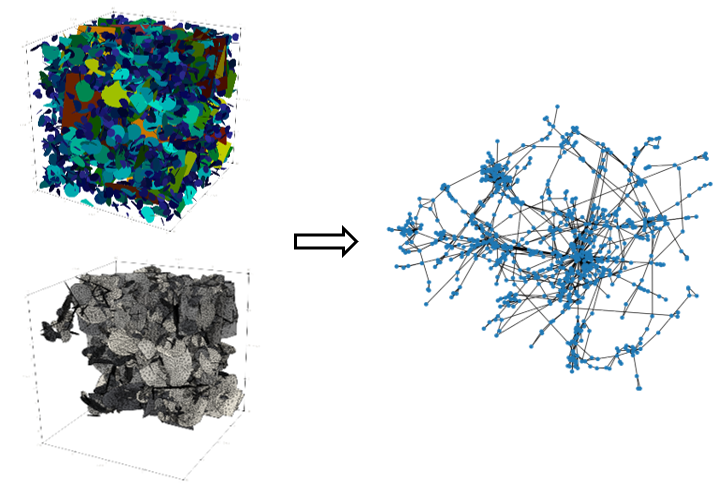
<center>
DFN and mesh replaced by a graph structure
</center>

### Theoretical background
The complex multiscale nature of fracture networks plays a key role in their flowing properties.
<br>
<br>
Graphs are mathematical objects made of nodes and edges that aim at studying complex systems ([Barabási et al.](https://journals.aps.org/rmp/abstract/10.1103/RevModPhys.74.47)). They lend themselves to the simplification of fracture networks by preserving their complex structure ([Andresen et al.](https://www.frontiersin.org/articles/10.3389/fphy.2013.00007/full))
<br>
<br>
However, graph-based representations have difficulties to preserve fracture flowing properties because fracture planes are replaced by one-dimensional edges. Doolaeghe et al. (submitted) propose edge conductance definition equivalent to the one of a fracture with constant aperture, for the two following graph-based DFN models:
- a fracture graph, where nodes represent fractures and edges exist between intersecting fractures 
- an intersection graph, where nodes represent intersections, and edges represent the fracture plane connecting two intersections. <br>

Doolaeghe et al. (submitted) show that these conductance definitions can be used to solve flow with a graph and estimate DFN flow properties.

The graph flow solving method can be found in [Karra et al.](https://journals.aps.org/pre/abstract/10.1103/PhysRevE.97.033304).

### What will you learn ?
- Creating a fracture graph and an intersection graph from a DFN (see Theoretical background). 
- Solving the flow with a fracture graph and intersection graph.
- Recovering flow results with post-process indicators: DFN equivalent permeability, flow by fracture, flow by intersection.
- Visualisation of the solution.

### DFN.Lab model

This tutorial is focused on the module __Graphs__.<br/>
The required modules are __Basis__, __Hydro__ and __BoundaryCondition__. <br/>
The module __IO__ is required for visualisation. <br/>
The module __Mesh__ and __Flow__ are also used at the end of the tutorial to compare the graph flow estimations to complete DFN flow simulation. 

We use [_pyvista_](https://docs.pyvista.org) for embedded visualization of generated networks in our notebook.
<br>
We use [_matplotlib_](https://matplotlib.org) to construct plots. 

_____________

## Graph construction from a DFN

In [1]:
import dfnlab.Basis as basis
import dfnlab.Generator as generator

system = basis.System()
system_size = 10
system.buildParallelepiped([0,0,0], system_size)
dfn = basis.DFN(system)
pgenerator = generator.PoissonGenerator(dfn,12345)
pgenerator.setSizesPowerlaw(4, lmin = 1, lmax = system_size)
pgenerator.setPositionsUniform()
pgenerator.setOrientationsUniform()
pgenerator.setStopPercolation(5)
pgenerator.generate()
dfn.cleanDFN()
dfn.computeIntersections() 
print("nf all={}".format(dfn.nbFractures()))

nf all=652


The fracture graph takes the DFN as input. <br>
In addition to the fracture vertices, vertices are automatically added for each intersection between fractures and geometries (system, wells or tunnels).

In [2]:
import dfnlab.Graphs as graphs

fgraph = graphs.DFNFractureGraph()
fgraph.create(dfn)
print("Num vertex fgraph={}".format(fgraph.numVertex())) 

Num vertex fgraph=879


Similarly, the intersection graph is created as follows:

In [3]:
igraph = graphs.DFNIntersectionGraph()
igraph.create(dfn)
print("Num vertex igraph={}".format(igraph.numVertex())) 

Num vertex igraph=1115


Boundary conditions are added as follows on both graphs. We define permeameter conditions here.

In [4]:
import dfnlab.BoundaryCondition as bc

boundaries = bc.DomainBoundaryCondition()
boundaries.setPermeameterCondition(dfn,10,2) #head gradient = 10, along y axis (2)

fgraph.addBoundaries(boundaries)
igraph.addBoundaries(boundaries)

The "keepBackbone" function selects vertices and edges that can flow with these boundary conditions. That means it removes, first, the isolated vertex clusters, i.e. clusters that are not connected to the two borders with dirichlet conditions, and, second, the dead-ends, i.e. iterativelly vertices with only one neighbor. 

In [5]:
fgraph.keepBackbone()
print("Num vertex fgraph backbone={}".format(fgraph.numVertex())) 
igraph.keepBackbone()
print("Num vertex igraph backbone={}".format(igraph.numVertex())) 

Num vertex fgraph backbone=412
Num vertex igraph backbone=882


It is possible to reconstruct DFN from these graphs, for example here from the fracture graph:

In [6]:
dfn_backbone = fgraph.createDFN(update = True)
print("nf backbone={}".format(dfn_backbone.nbFractures()))

nf backbone=364


The intersection graph can also be created directly from the fracture graph backbone: <br/>

In [7]:
igraph2 = graphs.DFNIntersectionGraph()
igraph2.create(fgraph)
igraph2.addBoundaries(boundaries)

## Graph flow solving

Fracture transmissivities must be added to the graphs. They must be constant by fracture. In this example, we chose T=1 for all fractures.

In [8]:
import dfnlab.Hydro as hydro

transmissivities = hydro.HydraulicProperties(dfn)
transmissivities.setConstant(1.)

fgraph.addTransmissivities(transmissivities)
igraph2.addTransmissivities(transmissivities)

We create an "DFNGraphFlow" object taking either a fracture or intersection graph as input. Then, we create the solving matrices.

In [9]:
fgraphFlow = graphs.DFNGraphFlow(fgraph)
igraphFlow = graphs.DFNGraphFlow(igraph2)

fgraphFlow.createSolvingMatrices()
igraphFlow.createSolvingMatrices()

Then vertices heads and edge flow are solved:

In [10]:
fgraphFlow.solveHeadAndFlow()
igraphFlow.solveHeadAndFlow()

## Comparison with real DFN flow simulations

In [11]:
import dfnlab.Mesh as mesh
import dfnlab.Flow as solver
mesh = mesh.DFNMesh(dfn_backbone) 
mesh.setCaracteristicLength(5) 
mesh.setResolutionIntersection(2)
mesh.setResolutionGeometry(2)
mesh.setMinimumEdgeLength(1)
mesh.setMaximumEdgeLength(5)
mesh.setGradation(2)  
mesh.generateMesh() 

flow = solver.solveDarcyProblem(mesh,boundaries,transmissivities)

Linear system building 
Time: to build the system: 0.144645 seconds. 
Taking account of the boundary conditions
Linear System solving
Time: to solve the system (intermediaire 1): 0.0273296 seconds. 
Time: to solve the system (intermediaire 2): 0.0018862 seconds. 
Time: to reconstruct the velocities: 0.0379493 seconds. 


We compare the equivalent permeability:

In [12]:
K_dfn = flow.hydraulicConductivity().getValue()
K_fgraph = fgraphFlow.getHydraulicConductivity()
K_igraph = igraphFlow.getHydraulicConductivity()

print("Permeability from DFN ={}".format(K_dfn))
print("Permeability from fracture graph ={}".format(K_fgraph))
print("Permeability from intersection graph ={}".format(K_igraph))

Permeability from DFN =0.029799953902907354
Permeability from fracture graph =0.036776442070349045
Permeability from intersection graph =0.032227832393876776


We compare the flow exchanged by intersection: 

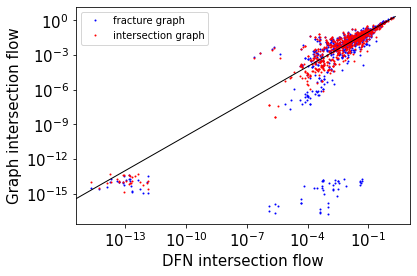

In [13]:
dfn_inter_flow = []
fgraph_inter_flow = []
igraph_inter_flow = []

fgraphFlow.computeDetailedExchangedFlows()
igraphFlow.computeDetailedExchangedFlows()

for inter in dfn_backbone.iterIntersectionsFractures():   
    frac = inter.getObject1()
    dfn_inter_flow.append(abs(flow.flowInIntersections().getValue(inter, frac)))
    fgraph_inter_flow.append(fgraphFlow.getIntersectionFlow(inter))
    igraph_inter_flow.append(igraphFlow.getIntersectionFlow(inter))
    
#plot
from sources.functions import plot_GraphsVsDFN

plot_GraphsVsDFN(dfn_inter_flow, fgraph_inter_flow, igraph_inter_flow, 'intersection flow')

And finally, the flow exchanged by fracture:

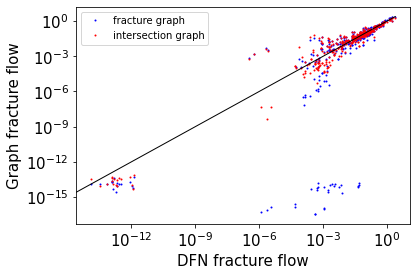

In [14]:
dfn_frac_flow = []
fgraph_frac_flow = []
igraph_frac_flow = []

for frac in dfn_backbone:   
    dfn_frac_flow.append(flow.flowInFracture().getValue(frac))
    fgraph_frac_flow.append(fgraphFlow.getFractureFlow(frac))
    igraph_frac_flow.append(igraphFlow.getFractureFlow(frac))
    
#plot
from sources.functions import plot_GraphsVsDFN

plot_GraphsVsDFN(dfn_frac_flow, fgraph_frac_flow, igraph_frac_flow, 'fracture flow')

## Graph visualisation

Edges with flow under a given threshold can be removed from the graphs. Here we remove edge flow under 10^-3 for a better vizualisation.<br>
(Warning: changing the graph structure by removing nodes or edges renders the graph flow post process functions unusable)

In [15]:
fgraphFlow.removeEdgesUnderFlowThreshold(10**-3)
igraphFlow.removeEdgesUnderFlowThreshold(10**-3)

Export functions using the VTK library are available in __IO__ for the graphs.

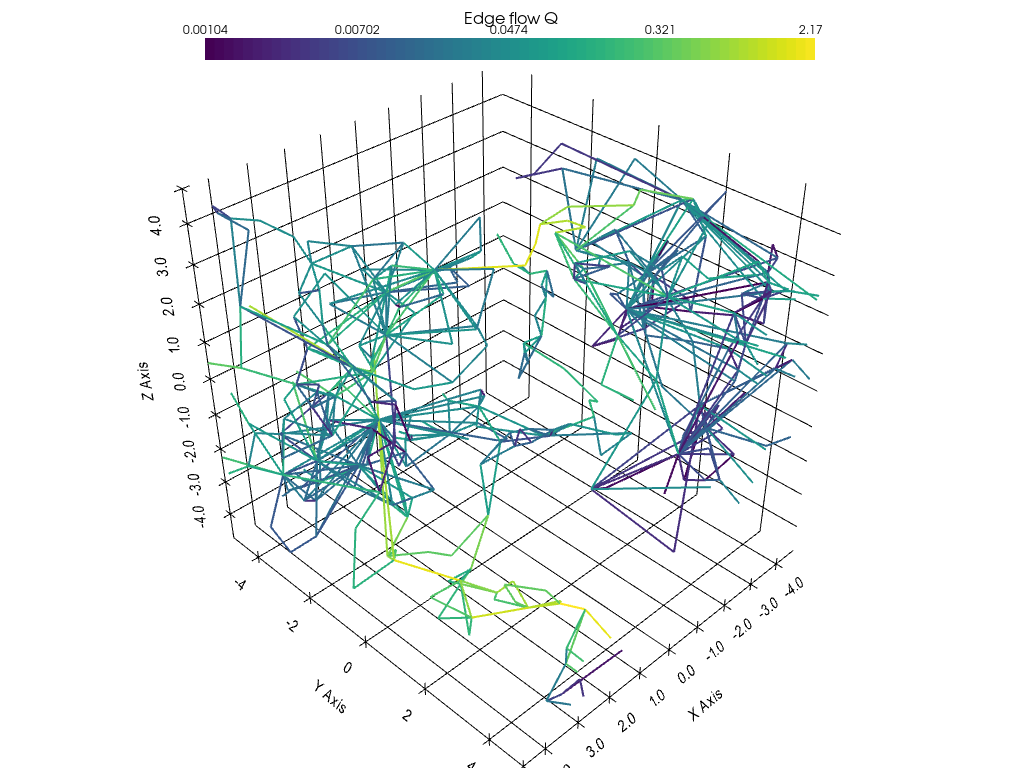

In [16]:
import os
import dfnlab.IO as io

writer = io.DFNIO_Object(fgraph, create = False)
writer.createVTKDataGraph(fgraphFlow)
writer.writeVTKOnGraph("fgraph.vtp")

from sources.functions import plot_flowGraph
plot_flowGraph("fgraph.vtp")